### Introduction

Given some information about a bullet, how do you model its velocity and trajectory when it is fired? When you fire a bullet presumably you want to hit something so this seems to be a pretty relevant question. The simplest answer is to just fire the bullet a bunch of times, see what happens (maybe with some fancy method of measurement), and write it down. Unfortunately this kind of sucks. The number of conditions and positions the bullet can be in make measuring infeasible, or at the very least annoying. To deal with this we've created ballistic models, which given some initial conditions can closely reproduce the trajectory and velocity of an actual bullet.

There are three forces making the bullet move. The first is the obvious one, which is the firing part, the bullet is moving forward rather quickly. The second is gravity, which pulls the bullet downward at a constant rate. These two are easy and can be modeled easily. The tricky one is air resistance. Air resistance slows the bullet down opposite to the direction its heading, but changes based on velocity, the shape of the bullet, and the atmospheric conditions. This is sort of a pain because the velocity is also changing over time. This also means it cannot be solved analytically so we have to model it.

Before we move on to talking more about air resistance it might be helpful to summarize the previous paragraph. These are the forces in equation form.

$$\mathbf{F} = m\mathbf{g} - \mathbf{F_d}$$

Now for air resistance.

$$\mathbf{F}_d= -{1 \over 2} \rho v^2 A C_d \mathbf{\hat v}$$

$C_d$ is the non-dimensional drag coefficient, $\rho$ is the density of the air the projectile travels through , $|v|$ is the magnitude of velocity, and $\mathbf{\hat v} = \frac{\mathbf{v}}{|\mathbf{v}|}$ the normalized velocity direction. $A$ is the cross-sectional area of the projectile. This is all sort of confusing which is good becuase we won't really be using it anyway. It has another measurement problem. To use this equation we would have to measure the coefficient of drag at a bunch of points, but for every bullet. We got into this because we didn't want to measure so this is a non-starter.

Fortunately because many other people had this problem there are reference rounds we can use. These have nicely measured drag coefficients and manufacturers give the ratio between a few common reference rounds (G1 and G7, G1 is very large G2 is little) and the rounds they sell. The higher the number the worse it flies through air and the closer it is to the reference round. This number is called the ballistic coefficient or $b_c$.

$$b_c = \frac{S_d}{f}.$$

$$f=\frac{C_d}{C^{\mathbf{G}}_{d}}$$

$$S_d = \frac{m}{A}$$

If you solve for $C_d$ and plug it in to the air resistance equation you get an equation only dependent on the reference projectile and the ballistic coefficient.

$$ \mathbf{a_d} = -\frac{1}{2b_c} \rho C_d^G(m) |v|^2\mathbf{\hat v}.$$

Now that we have that all we need to do is numerically approximate the position and velocity based on these equations!









### Methods

Numerical methods are described in sufficient detail to allow a reader to know where to look for more information. You are free to take information from the notebooks I provide. Some means of determining if the output is correct is developed. Is there sufficient detail to make the experiments conducted reproducable?

To approximate the bullet we are using a three part solver. The first just calls the other ones over a range of small time intervals and stores the results.

In [1]:
from sim import EulerRichardson

def solve_ode(f,tspan, y0, method=EulerRichardson, *args, **options):
    t0, tf = tspan
    dt = options.get('first_step', 0.01)

    t = [t0]
    y = [y0]

    while t[-1] < tf:
        y_c = y[-1]
        t_c = t[-1]

        y_new = method(dt, f, t_c, y_c, args)
        t_new = t_c + dt

        y.append(y_new)
        t.append(t_new)

    return np.array(t), np.array(y)

The second approximates the change over a period of time. These first two are kind of important but not really, if you know calculus the EulerRichardson function is just numerically integrating the function below.

In [2]:
def EulerRichardson(dt, f, t, y, args):
    k1 = f(t, y, *args)
    y_mid = y + k1 * (dt/2)
    k2 = f(t + dt/2, y_mid, *args)
    return y + k2 * dt

This is the part I think is cool. This projectile function returns the derivatives of the state vector. Basically given a position and a velocity it gives the change in position and velocity. That is nice because with a bullet you have a position, and they usually give you an initial velocity. If you squint you can see the equations expressed in this code. I'll show them again to make things easier and add some comments to show where they correspond.

This is the force in each direction.

$$ a_x = ~~- \mathbf{F_d}/m  \cdot \mathbf{\hat x}$$
$$ a_y = g - \mathbf{F_d}/m  \cdot \mathbf{\hat y}$$





In [3]:
def projectile(t,y,b):
  # previous state
  x, y, vx, vy = y
  # needed for unit vectors
  speed = np.sqrt(vx**2 + vy**2)

  # g and Fd
  g = b.g
  drag = b.get_drag(speed)

  # unit vectors at the end of the equation
  u_x = vx / speed
  u_y = vy / speed

  # Force in each direction, no need for mass (becuase not a force? i am not totally clear on force vs not a force tbh)
  ax = -drag * u_x
  ay = g - (-drag * u_y)

  return np.array([vx, vy, ax, ay])

The force of drag is also similar to the equations above.
$$ \mathbf{a_d} = -\frac{1}{2b_c} \rho C_d^G(m) |v|^2\mathbf{\hat v}.$$


In [4]:
def get_drag(self, speed):
  # need mach to get c_d
  mach = speed / self.vs
  # get c_d. this is just a function that takes in a mach number
  # and returns the reference projectiles c_d at that mach number.
  # (just like the equation)
  cd = self.cd(mach)
  #      - 1/2bc             * p        * |v|^2      * cd
  drag = 0.5 * (1 / self.bc) * self.rho * speed ** 2 * cd
  return drag

With all of this we can model the bullet! To nicely encapsulate the model in code I turned it into a python class but that is not really important. This is the b you see as a parameter in the projectile function. get_drag is a method of b.

Before we go on to using all of this it is important to cover how I know I'm right. I will be using the projectile data that is given by the manufacturer and checking how close I am. This is the manufacturer data I am passing in below.

With that out of the way lets use the model on an actual cartridge. For this I am using Hornady's 50 BMG. It's pretty simple. We just pass in our initial position and velocity as well as the ballistic coefficient (all given by the manufacturer). Then we call plot_velocity() which is just a wrapper around the solve_ode function we saw earlier and plot the results.

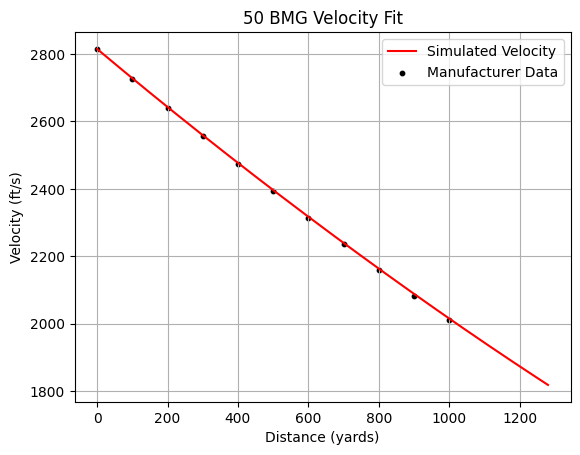

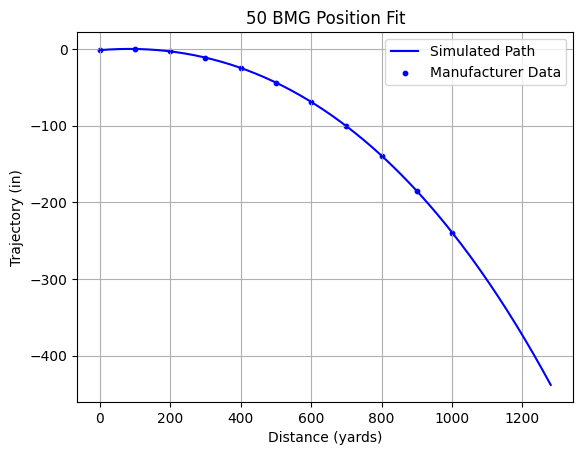

+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  Distance (yards)  |    0     |   100    |   200    |   300    |   400    |   500    |   600    |   700    |   800    |   900    |   1000   |
+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|     Drop (in)      |  -1.500  |  0.000   |  -3.200  | -11.400  | -24.900  | -44.000  | -69.300  | -101.000 | -139.700 | -185.900 | -240.100 |
|  Drop Error (in)   |  0.000   |  -0.000  |  0.055   |  -0.308  |  0.779   |  -0.243  |  1.393   |  -0.497  |  1.413   |  2.144   |  1.093   |
|    Speed (ft/s)    | 2815.000 | 2727.000 | 2641.000 | 2557.000 | 2474.000 | 2393.000 | 2314.000 | 2235.000 | 2159.000 | 2083.000 | 2010.000 |
| Speed Error (ft/s) |  -0.002  |  -0.318  |  1.759   |  -1.200  |  5.972   |  1.800   |  6.142   |  2.501   |  5.760   |  7.468   |  5.

In [5]:
from sim import G1, G7, BallisticModel
import numpy as np
title = "50 BMG"

manufacturer_data = (
  np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]),
  np.array([2815, 2727, 2641, 2557, 2474, 2393, 2314, 2235, 2159, 2083, 2010]),
  np.array([-1.5, 0.0, -3.2, -11.4, -24.9, -44.0, -69.3, -101.0, -139.7, -185.9, -240.1]),
)

position = (0, -1.5 / 12)
velocity = (2815, 0)
b = BallisticModel(bc=1.05, position=position, velocity=velocity, manufacturer_data=manufacturer_data, reference=G1)

b.sight(300)
b.plot_velocity(title)
b.plot_position(title)
b.print_errors()

Pretty nice!

### Analysis

It looks like the model is decently accurate in the base case. We're within an inch at all times but usually closer, all the way out to 1000 yards. Velocity is a little worse, probably because I am optimizing for position when I find the optimal launch angle. Still less than half a percent error for both in the worst case. Let's try another round and find out more.

#### 338 Lapua 285 gr

The first thing I was curious about was whether it mattered which reference model I used. I am going to try the same bullet with both.


Optimal angle: 0.06 degrees
 MSE: 0.013370545027044078


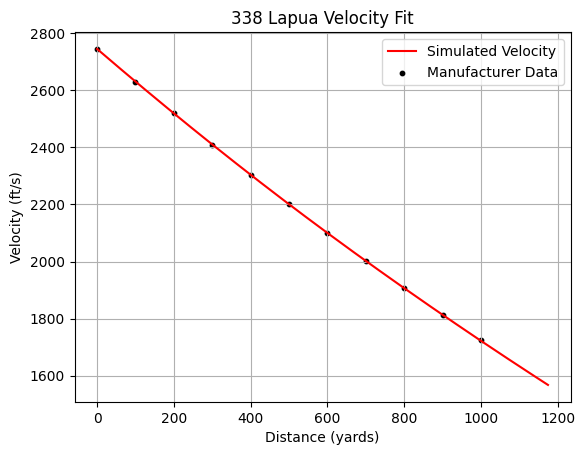

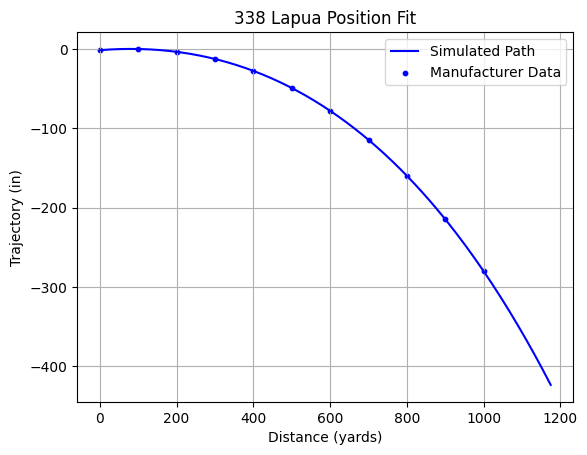

+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  Distance (yards)  |    0     |   100    |   200    |   300    |   400    |   500    |   600    |   700    |   800    |   900    |   1000   |
+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|     Drop (in)      |  -1.500  |  0.000   |  -3.500  | -12.600  | -27.600  | -49.100  | -77.900  | -114.500 | -159.900 | -214.800 | -280.300 |
|  Drop Error (in)   |  0.000   |  -0.015  |  -0.177  |  -0.020  |  -0.418  |  -0.012  |  -0.042  |  -1.083  |  -0.029  |  0.476   |  0.483   |
|    Speed (ft/s)    | 2745.000 | 2630.000 | 2519.000 | 2410.000 | 2304.000 | 2200.000 | 2099.000 | 2001.000 | 1906.000 | 1814.000 | 1724.000 |
| Speed Error (ft/s) |  -0.002  |  2.423   |  -1.490  |  0.198   |  -2.164  |  1.041   |  1.154   |  -1.163  |  0.588   |  0.005   |  -1

In [6]:
title = "338 Lapua"

manufacturer_data = (
  np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]),
  np.array([2745, 2630, 2519, 2410, 2304, 2200, 2099, 2001, 1906, 1814, 1724]),
  np.array([-1.5, 0.0, -3.5, -12.6, -27.6, -49.1, -77.9, -114.5, -159.9, -214.8, -280.3]),
)

position = (0, -1.5 / 12)
velocity = (2745, 0)
b = BallisticModel(bc=0.394, position=position, velocity=velocity, manufacturer_data=manufacturer_data, reference=G7)

b.optimize()
b.solve_trajectory()

b.plot_velocity(title)
b.plot_position(title)
b.print_errors()

Optimal angle: 0.06 degrees
 MSE: 0.011502399729736953


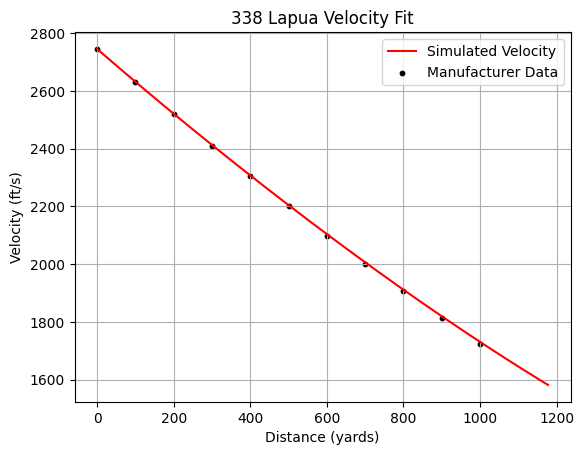

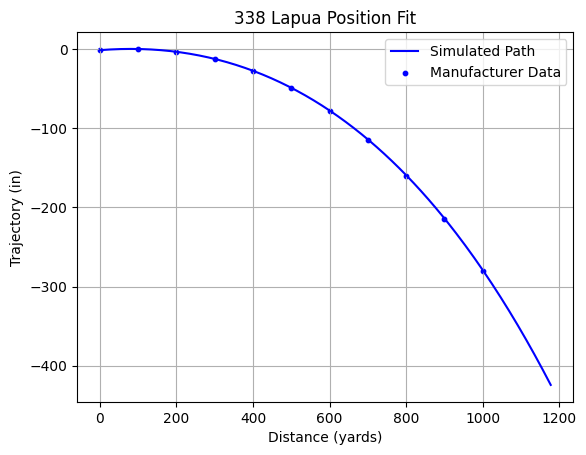

+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  Distance (yards)  |    0     |   100    |   200    |   300    |   400    |   500    |   600    |   700    |   800    |   900    |   1000   |
+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|     Drop (in)      |  -1.500  |  0.000   |  -3.500  | -12.600  | -27.600  | -49.100  | -77.900  | -114.500 | -159.900 | -214.800 | -280.300 |
|  Drop Error (in)   |  0.000   |  -0.001  |  -0.148  |  0.021   |  -0.369  |  0.039   |  0.008   |  -1.039  |  -0.001  |  0.458   |  0.352   |
|    Speed (ft/s)    | 2745.000 | 2630.000 | 2519.000 | 2410.000 | 2304.000 | 2200.000 | 2099.000 | 2001.000 | 1906.000 | 1814.000 | 1724.000 |
| Speed Error (ft/s) |  -0.002  |  3.038   |  -0.043  |  2.438   |  0.746   |  4.308   |  4.540   |  2.414   |  4.720   |  5.380   |  6.

In [7]:
title = "338 Lapua"

manufacturer_data = (
  np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]),
  np.array([2745, 2630, 2519, 2410, 2304, 2200, 2099, 2001, 1906, 1814, 1724]),
  np.array([-1.5, 0.0, -3.5, -12.6, -27.6, -49.1, -77.9, -114.5, -159.9, -214.8, -280.3]),
)

position = (0, -1.5 / 12)
velocity = (2745, 0)
b = BallisticModel(bc=0.789, position=position, velocity=velocity, manufacturer_data=manufacturer_data, reference=G1)

b.optimize()
b.solve_trajectory()

b.plot_velocity(title)
b.plot_position(title)
b.print_errors()

It looks like it doesn't make too much of a difference. The G1 round which is not as similar gets a smaller error.

#### Improvements

I tried several improvements over the current model. All of them involved some modification of the drag function over time. None of them generalized well.



### Interpretations

Cool assignment overall, it seemed like a very simple problem at first, then thought it was hard, now it seems easy again. My main takeaway from this whole things was to keep track of units and that the data on the manufacturers website is not necessarily accurate. The first bullet I tried was consistently off every time, no matter what I tried. I thought it was my units, so I changed them and made things worse. Eventually when I tried another bullet it was off as well. I fixed the issues and I got the model I'm using now. When I went back to that original bullet I expected everything to work just as well. Unfortunately I was again way off and had no idea why. Eventually I tried just changing the ballistic coefficient to something random and was much closer. Suspicion sank in and I subtracted 1 by the bc, plugged it in and got the fit I was looking for. Here is that bullet with the manufacturer bc and with mine.



Optimal angle: 0.16 degrees
 MSE: 12.736569823273657


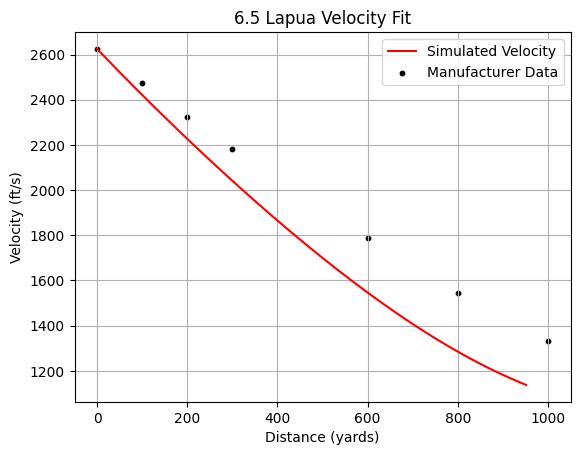

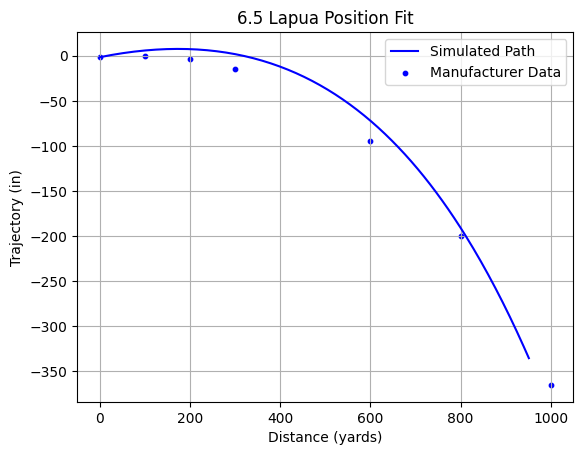

+--------------------+----------+----------+----------+----------+----------+----------+
|  Distance (yards)  |    0     |   100    |   200    |   300    |   600    |   800    |
+--------------------+----------+----------+----------+----------+----------+----------+
|     Drop (in)      |  -1.600  |  0.000   |  -4.000  | -15.000  | -94.000  | -200.000 |
|  Drop Error (in)   |  0.000   |  5.870   |  11.299  |  16.718  |  21.162  |  10.304  |
|    Speed (ft/s)    | 2625.000 | 2473.000 | 2325.000 | 2183.000 | 1786.000 | 1545.000 |
| Speed Error (ft/s) |  -0.010  | -53.245  | -100.696 | -143.052 | -242.400 | -258.733 |
+--------------------+----------+----------+----------+----------+----------+----------+


In [8]:
title = "6.5 Lapua"
man_x = np.array([0, 100, 200, 300, 600, 800, 1000])
man_v = np.array([2625, 2473, 2325, 2183, 1786, 1545, 1332])
man_y = np.array([-1.6, 0, -4, -15, -94, -200, -365])

manufacturer_data = (
  np.array([0, 100, 200, 300, 600, 800, 1000]),
  np.array([2625, 2473, 2325, 2183, 1786, 1545, 1332]),
  np.array([-1.6, 0, -4, -15, -94, -200, -365]),
)

position = (0, -1.6 / 12)
velocity = (2625, 0)
b = BallisticModel(bc=0.424, position=position, velocity=velocity, manufacturer_data=manufacturer_data, reference=G1)

b.optimize()
b.solve_trajectory()

b.plot_velocity(title)
b.plot_position(title)
b.print_errors()

Optimal angle: 0.06 degrees
 MSE: 0.04829450435854436


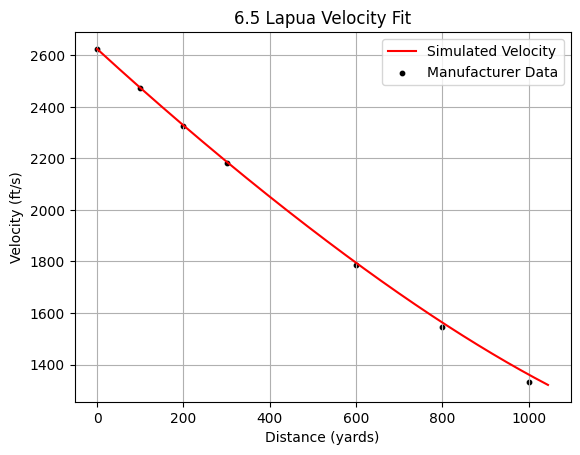

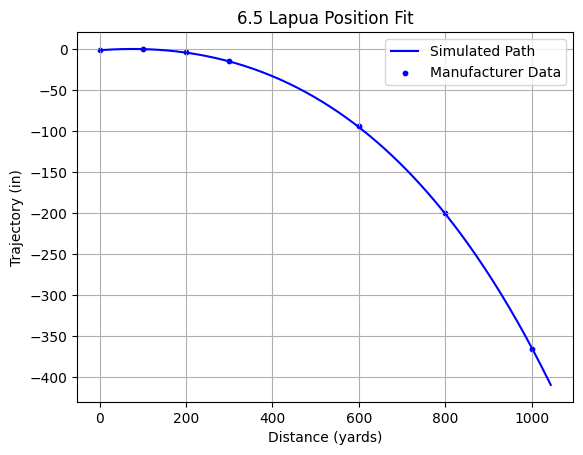

+--------------------+----------+----------+----------+----------+----------+----------+----------+
|  Distance (yards)  |    0     |   100    |   200    |   300    |   600    |   800    |   1000   |
+--------------------+----------+----------+----------+----------+----------+----------+----------+
|     Drop (in)      |  -1.600  |  0.000   |  -4.000  | -15.000  | -94.000  | -200.000 | -365.000 |
|  Drop Error (in)   |  0.000   |  -0.245  |  -0.366  |  -0.695  |  -1.194  |  -1.133  |  1.877   |
|    Speed (ft/s)    | 2625.000 | 2473.000 | 2325.000 | 2183.000 | 1786.000 | 1545.000 | 1332.000 |
| Speed Error (ft/s) |  -0.002  |  -1.585  |  6.420   |  0.043   |  8.960   |  16.894  |  29.027  |
+--------------------+----------+----------+----------+----------+----------+----------+----------+


In [9]:
man_x = np.array([0, 100, 200, 300, 600, 800, 1000])
man_v = np.array([2625, 2473, 2325, 2183, 1786, 1545, 1332])
man_y = np.array([-1.6, 0, -4, -15, -94, -200, -365])

manufacturer_data = (
  np.array([0, 100, 200, 300, 600, 800, 1000]),
  np.array([2625, 2473, 2325, 2183, 1786, 1545, 1332]),
  np.array([-1.6, 0, -4, -15, -94, -200, -365]),
)

position = (0, -1.6 / 12)
velocity = (2625, 0)
b = BallisticModel(bc=0.576, position=position, velocity=velocity, manufacturer_data=manufacturer_data, reference=G1)

b.optimize()
b.solve_trajectory()

b.plot_velocity(title)
b.plot_position(title)
b.print_errors()

Some future work might be more accurate measures of Cd or an improved numerical integration function.